In [185]:
import tweepy
import pandas as pd
import re
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


In [187]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

In [299]:
articles_df = pd.read_csv("data.csv")
articles_df.reset_index(inplace=True, drop=True)

In [300]:
articles_df.columns = ['ArticleName', 'Summary', 'Link']

In [144]:
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", '', text)
    text = re.sub(r"#", '', text)
    text = re.sub(r"\\", '', text)
    text = re.sub(r"\n", '', text)
    text = re.sub(r"RT[\s]+", "", text)
    text = re.sub(r"https?:\/\/\s+", '', text)  
    text = re.sub(r"(?:^|\W)crypto(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)nft(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)meta(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)https(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)t co(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)facebook(?:$|\W)", '', text)
    text = re.sub(r"\\", '', text)
    return text

In [200]:
def calculate_sentiment(text, tokenizer, model):
    tokens = tokenizer.encode(text, return_tensors='pt', max_length=512,
                              padding=True, truncation=True, add_special_tokens = True)
    result = model(tokens)
    final_num = int(torch.argmax(result.logits)) + 1
    return final_num

In [145]:
def more_cleaning(tweet, lst_of_words):
    for word in lst_of_words:
        if word in tweet:
            tweet = tweet.replace(word, "")
    return tweet

In [146]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getAPolarity(text):
    return TextBlob(text).sentiment.polarity

In [147]:
def remove_stopwords(tweet):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(tweet)
    filtered_tokens = []
    
    for word in word_tokens:
        if word.lower() not in stop_words:
            filtered_tokens.append(word)
            
    return " ".join(filtered_tokens)

In [148]:
def create_wordscloud(tweets, title):
    plt.title(title)
    allWords = " ".join([twt for twt in tweets])
    wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allWords)

    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [276]:
def export_text(text, name):
    with open(name, "w+", encoding="utf-8") as write_obj:
        write_obj.write(text)

In [293]:
def remove_polish_entries(text, df, col_name):
    if "się" in text or "que" in text:
        ind = df.index[df[col_name] == text]
        df.drop(axis=0, index=ind[0], inplace=True)
        print(text)
        
        

In [301]:
articles_df.dropna(inplace=True)
articles_df.reset_index(inplace=True, drop = True)
len(articles_df)

141

In [302]:
articles_df["ArticleName"] = articles_df["ArticleName"].apply(clean_text)
articles_df["Summary"] = articles_df["Summary"].apply(clean_text)
# articles_df["Summary"].apply(lambda x:remove_polish_entries(x, articles_df, "Summary"))

In [283]:
#Exporting Negative Text
export_text(" ".join([sumar for sumar in articles_df[articles_df["Sentiment"] == 1]["Summary"]]), "negative_file.txt")

In [292]:
# Exporting whole text
export_text(" ".join([sumar for sumar in articles_df["Summary"]]), "text_file.txt")

In [303]:
len(articles_df)

141

In [304]:
# Sentiment nums from BERT deep learning model
articles_df["Sentiment"] = articles_df["Summary"].apply(lambda x: calculate_sentiment(x, tokenizer, model))

In [158]:
# Sentiment from TextBlob library
articles_df["Subjectivity"] = articles_df["Summary"].apply(getSubjectivity)
articles_df["Polarity"] = articles_df["Summary"].apply(getAPolarity)


In [224]:
articles_df.columns

Index(['ArticleName', 'Summary', 'Link', 'Sentiment'], dtype='object')

In [290]:
articles_df

,ArticleName,Summary,Link,Sentiment
1,"Meta — different name, same mess | Opinion | D...","Different Name, Same MessYou have to hand it t...",https://www.dw.com/en/opinion-meta-different-n...,2
2,Americans Don't Like 'Meta' Name Or Care About...,Americans Don'T Like 'Meta' Name Or Care About...,https://morningconsult.com/2021/11/02/meta-fac...,2
4,"Opinion | Goodbye, Facebook. Welcome to the Me...","Goodbye, Facebook. Welcome To The Meta Zone.It...",https://www.washingtonpost.com/opinions/2021/1...,1
5,Opinion: Mark Zuckerberg doesn't have to contr...,Facebook'S Metaverse Isn'T The Only FutureWhat...,https://www.washingtonpost.com/opinions/2021/1...,2
6,The expert's view- Facebook's move to Meta - 2...,Transform Magazine: The Expert'S View- Faceboo...,https://www.transformmagazine.net/articles/202...,2
...,...,...,...,...
122,Facebook patents show Meta wants to track your...,META PLATFORMS AKTIE RatingWie bewerten Sie di...,https://www.finanzen.net/aktien/rating/facebook,1
123,META PLATFORMS (EX FACEBOOK) AKTIE Rating,How Facebook'S New 'Meta' Branding Began With ...,https://rifnote.com/2021/10/31/how-facebooks-n...,1
124,Meta zastąpi Facebooka - o co chodzi? - ESKA.pl,'Meta' Is The New Name For FacebookFacebook ha...,https://screenrant.com/facebook-name-change-me...,2
125,Jak używać metatagu „og” (Open Graph) do udost...,"Jak Używać Metatagu „Og"" Do Udostępniania Na F...",https://qa-stack.pl/programming/11616697/how-t...,4


In [254]:
# Removing Stopwords
articles_df["Summary"] = articles_df["Summary"].apply(remove_stopwords)


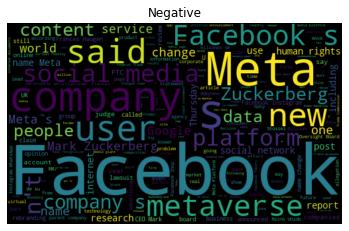

In [255]:
# Creating Wordcloud
create_wordscloud(articles_df[articles_df["Sentiment"] == 1]["Summary"], "Negative")

In [164]:
def tweetPositivity(score):
    if score > 0:
        return "Positive"
    if score == 0:
        return "Neutral"
    if score < 0:
        return "Negative"

In [165]:
articles_df["Analysis"] = articles_df["Polarity"].apply(tweetPositivity)

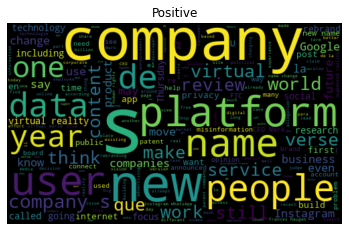

In [180]:
create_wordscloud(articles_df[articles_df["Analysis"] == "Positive"]["Summary"], "Positive")

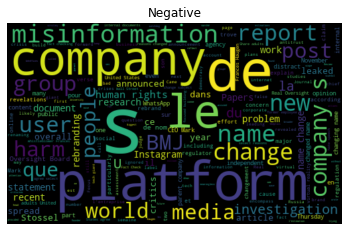

In [181]:
create_wordscloud(articles_df[articles_df["Analysis"] == "Negative"]["Summary"], "Negative")

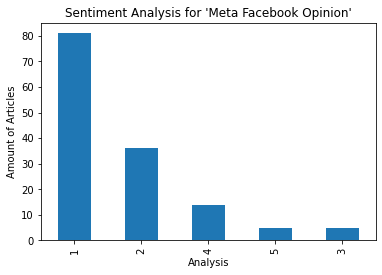

In [305]:
plt.title("Sentiment Analysis for 'Meta Facebook Opinion'")
plt.xlabel("Analysis")
plt.ylabel("Amount of Articles")
articles_df["Sentiment"].value_counts().plot(kind="bar")
plt.show()

In [306]:
articles_df["Sentiment"].value_counts()

1    81
2    36
4    14
5     5
3     5
Name: Sentiment, dtype: int64